# A Tensorflow 2 implementation of the paper [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://arxiv.org/pdf/1608.03981.pdf)

In this implementation the patches are not precomputed. Instead, at each epoch, a random patch is extracted from each image, and we need to train for more epochs.

Before running the code, make sure to allow colab to access your drive storage.

My data is located in the path colab --> dncnn --> data.


In [1]:
%cd drive/My\ Drive/colab/dncnn

/content/drive/My Drive/colab/dncnn


## 1 - Load Tensorboard, Imports and global variables

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
import random
import numpy as np
import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
#from dncnn import DnCNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # for dataset configuration

# Training variables
BATCH_SIZE = 64
EPOCHS = 500
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Network parameters
DEPTH = 17

# Data preparation variables
NOISE_STD = 25
SCALES = [1, 0.9, 0.8, 0.7] # used for data augmentation
TRAIN_PATCH_DIM = 40
TEST_DIM = 180

# Train and test set directories
TEST_DIR = 'data/test/*.jpg'
TRAIN_DIR = 'data/train/*.jpg'

# 2 - Model definition

Definition of the VGG model described in the paper.
Also, out of curiosity, I have implemented a model with similar structure but inspired to ResNet 18.

In [5]:
class DnCNN(Model):
    def __init__(self, depth=17):
        super(DnCNN, self).__init__()

        # Initial conv + relu
        self.conv1 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he_uniform())

        # Depth - 2 cnv+bn+relu layers 
        self.conv_bn_relu = [ConvBNReLU() for i in range(depth - 2)]

        # final conv
        self.conv_final = Conv2D(1, 3, padding='same', kernel_initializer=he_uniform())

    def call(self, x):
        x = self.conv1(x)
        for cbr in self.conv_bn_relu:
            x = cbr(x)
        return self.conv_final(x)


class ConvBNReLU(Model):
    def __init__(self):
        super(ConvBNReLU, self).__init__()
        self.conv = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn = BatchNormalization()
        self.relu = ReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)


In [6]:
class DnCNNRN(Model):
    def __init__(self, depth=8):
        super(DnCNNRN, self).__init__()
        
        # Initial conv + relu (same as in DnCNN)
        self.conv = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.relu = ReLU()

        # Use 8 ResNet-inspired blocks (16 layers)
        self.rn_layers = [BasicBlock() for i in range(depth)]

        # Final conv
        self.conv_final = Conv2D(1, 3, padding='same', kernel_initializer=he_uniform())

    def call(self, x):
        x = self.conv(x)
        x = self.relu(x)
        for layer in self.rn_layers:
            x = layer(x)
        return self.conv_final(x)


class BasicBlock(Model):
    def __init__(self):
        
        # One ResNet block is:
        # conv1 - bn1 - relu
        # conv2 - bn2
        # residual connection
        # relu

        super(BasicBlock, self).__init__()

        self.conv1 = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.conv2 = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn2 = BatchNormalization()

    def call(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity

        out = self.relu(out)

        return out

## 3 - Data loading and data augmentation for training set and test set.

In [7]:
def gaussian_noise_layer(dim):
    '''generate noise mask of given dimension'''
    std = NOISE_STD # random.randint(0, 55) for blind denoising
    noise = tf.random.normal(shape=[dim, dim, 1], mean=0.0, stddev=std, dtype=tf.float32)/255.0
    return noise


def augment(image):
    '''prepare and augment input image, and generate noise mask'''
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=1)

    # augmentation 1:
    # rescale input to obtain crops at different level of detail
    h, w = float(tf.shape(image)[0]), float(tf.shape(image)[1])
    s = random.choice(SCALES)
    image = tf.image.resize(image, [int(h*s),int(w*s)])/250
    
    # crop random patch
    image = tf.image.random_crop(image, size=[TRAIN_PATCH_DIM, TRAIN_PATCH_DIM, 1])

    # augmentation 2: random flip
    image = tf.image.random_flip_left_right(image)

    # augmentation 3: random rotation (0, 90, 180 or 270 degrees)
    for i in range(np.random.randint(4)):
      image = tf.image.rot90(image)

    # generate noise mask
    noise = gaussian_noise_layer(TRAIN_PATCH_DIM)

    # sum image and noise, clip values between 0 and 1
    noisy_image = tf.clip_by_value(image + noise, 0, 1)

    return noisy_image, noise, image

def configure_for_train(ds):
    '''configure loading and batching for training set'''
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [8]:
def augment_test(image):
    '''load test image'''

    # No augmentation and different size from training
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize_with_crop_or_pad(image, 180, 180)
    image = tf.image.convert_image_dtype(image, tf.float32)
    noise = gaussian_noise_layer(180)
    noisy_image = tf.clip_by_value(image + noise, 0, 1)

    return noisy_image, noise, image

def configure_for_test(ds):
    '''configure loading and batching for training set'''

    # No random shuffle
    ds = ds.cache()
    ds = ds.map(augment_test, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

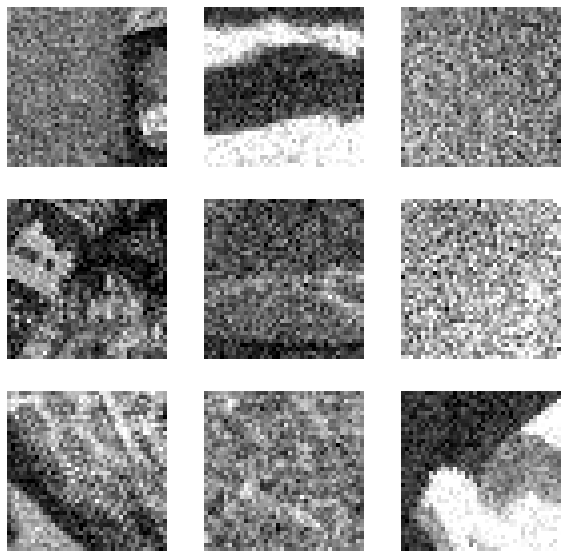

In [9]:
# Load train and test set
train_ds = tf.data.Dataset.list_files(TRAIN_DIR)
train_ds = configure_for_train(train_ds)
test_ds = tf.data.Dataset.list_files(TEST_DIR)
test_ds = configure_for_test(test_ds)

# Show some training patches 
image_batch, target_batch, _ = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")

## 4 Training and test step

In [10]:
@tf.function
def train_step(images, targets, true):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(targets, predictions)
        metric = tf.image.psnr(images-predictions, true,  max_val=1.0)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_metric(metric)

@tf.function
def test_step(images, labels, true):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    t_metric = tf.image.psnr(images-predictions, true,  max_val=1.0)

    test_loss(t_loss)
    test_metric(t_metric)

## 5 - Start tensorboard

If it's the first time you run this code and do not have a logs folder yet, it will be created when you start the training and the data will be visualized correctly in tensorboard.

Loss and PSNR for both training and test set will be logged during training.

In [11]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

## 6 - Start training!

In [12]:
# define model, loss function and optimizer
model = DnCNN()
loss_object = MeanSquaredError()
optimizer = tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=LEARNING_RATE)

# these objects keep track of losses and metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_metric = tf.keras.metrics.Mean(name='train_metric')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_metric = tf.keras.metrics.Mean(name='test_metric')

In [13]:
# Set tensorflow dir for the experiment
experiment_name = '/vgg_final'
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/' + current_time + experiment_name
summary_writer = tf.summary.create_file_writer(log_dir)


for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_metric.reset_states()
    test_loss.reset_states()
    test_metric.reset_states()

    # training loop
    for images, targets, true in train_ds:
        train_step(images, targets, true)
    
    # test loop
    for test_images, test_labels, test_true in test_ds:
        test_step(test_images, test_labels, test_true)

    # log losses and metrics
    with summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
        tf.summary.scalar('train_psnr', train_metric.result(), step=epoch)
        tf.summary.scalar('test_loss', test_loss.result(), step=epoch)
        tf.summary.scalar('test_psnr', test_metric.result(), step=epoch)

## 7 - Save model and weights

In [14]:
# need weights to load the model for inference
model.save_weights('weights/vgg_final')

In [15]:
# need whole model for post-training quantization
model.save('saved_model/vgg_final') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/vgg_final/assets


## 8 - Check results on Set12

In [16]:
# load trained model
model = DnCNN()
model.load_weights('weights/vgg_final')

In [18]:
def augment_12(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_png(image,1)
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize_with_crop_or_pad(image, 180, 180)
    image = tf.image.convert_image_dtype(image, tf.float32)
    noise = gaussian_noise_layer(180)

    return image + noise, noise, image

def configure_for_12(ds):
    ds = ds.cache()
    ds = ds.map(augment_12, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(12)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


@tf.function
def test_12(images, labels, true):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    t_metric = tf.image.psnr(images-predictions, true,  max_val=1.0)

    test_loss(t_loss)
    test_metric(t_metric)

# load and evaluate the 12 images
dir_12 = 'data/12/*.png'

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_metric = tf.keras.metrics.Mean(name='test_metric')
test_loss.reset_states()
test_metric.reset_states()
ds_12 = tf.data.Dataset.list_files(dir_12)
ds_12 = configure_for_12(ds_12)


for test_images, test_labels, test_true in ds_12:
    test_12(test_images, test_labels, test_true)
print(test_loss.result())
print(test_metric.result())

tf.Tensor(0.0018279841, shape=(), dtype=float32)
tf.Tensor(27.479126, shape=(), dtype=float32)


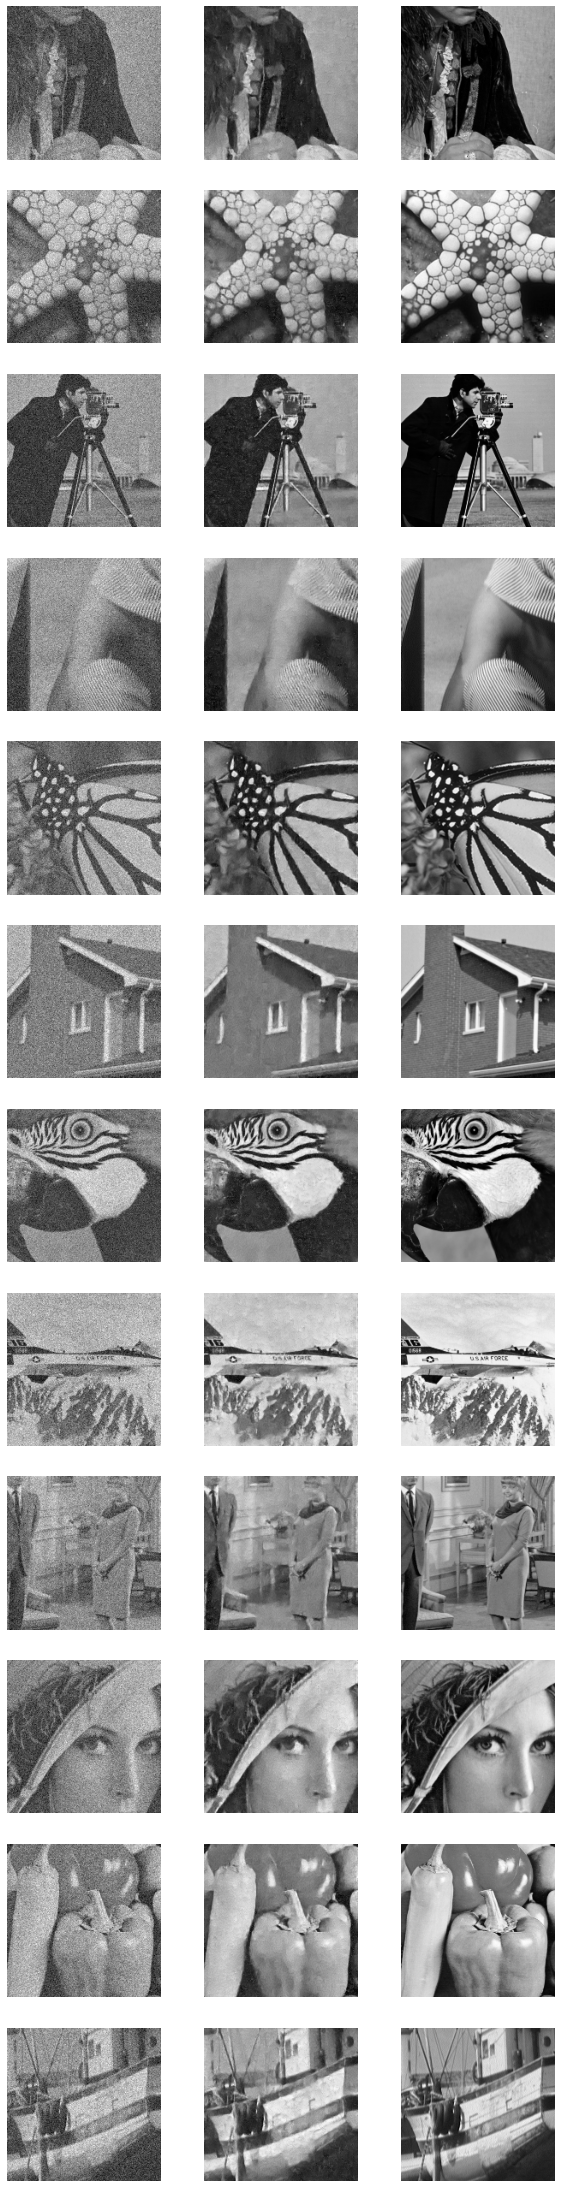

In [19]:
# Plot the results
# from left to right:
# noisy image, prediction, true image
image_batch, target_batch, true_batch = next(iter(ds_12))
predictions = model(image_batch, training=False)

columns = 3
rows = 12
fig = plt.figure(figsize=(10, 40))
for i in range(rows):
    fig.add_subplot(rows,columns,1+(i*columns))
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,2+(i*columns))
    plt.imshow((image_batch[i]-predictions[i]).numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,3+(i*columns))
    plt.imshow(true_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")

plt.show()